## Parallelization

In [15]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from pandarallel import pandarallel

from pa_lib import file

pandarallel.initialize(nb_workers=8)

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 8 workers


In [16]:
df = pd.DataFrame(dict(id=[1,1,2,2,3,3,4,4], nr=[1,2,3,4,5,6,7,8]))

In [21]:
def f(df):
    return df.agg(['sum', 'min', 'max'])

res1 = df.groupby('id').apply(f)

In [22]:
res2 = df.groupby('id').parallel_apply(f)
res1.equals(res2)

False

In [23]:
import pandas as pd
import itertools
import time
import multiprocessing
from typing import Callable, Tuple, Union

def groupby_parallel(groupby_df: pd.core.groupby.DataFrameGroupBy,
                     func: Callable[[Tuple[str, pd.DataFrame]], Union[pd.DataFrame, pd.Series]],
                     num_cpus: int=multiprocessing.cpu_count() - 1,
                     logger: Callable[[str], None]=print) -> pd.DataFrame:
    """Performs a Pandas groupby operation in parallel.
    Example usage:
        import pandas as pd
        df = pd.DataFrame({'A': [0, 1], 'B': [100, 200]})
        df.groupby(df.groupby('A'), lambda row: row['B'].sum())
    Authors: Tamas Nagy and Douglas Myers-Turnbull
    """
    start = time.time()
    logger("\nUsing {} CPUs in parallel...".format(num_cpus))
    with multiprocessing.Pool(num_cpus) as pool:
        queue = multiprocessing.Manager().Queue()
        result = pool.starmap_async(func, [(name, group) for name, group in groupby_df])
        cycler = itertools.cycle('\|/―')
        while not result.ready():
            logger("Percent complete: {:.0%} {}".format(queue.qsize()/len(groupby_df), next(cycler)), end="\r")
            time.sleep(0.4)
        got = result.get()
    logger("\nProcessed {} rows in {:.1f}s".format(len(got), time.time() - start))
    return pd.concat(got)

In [29]:
df = pd.DataFrame({'A': [0, 1, 0, 1], 'B': [100, 200, 300, 400]})
def f(df):
    return df.loc[:,'B'].sum()
groupby_parallel(df.groupby('A'), f)


Using 7 CPUs in parallel...


TypeError: f() takes 1 positional argument but 2 were given

## Contingency Tables

In [1]:
import numpy as np
import pandas as pd

In [2]:
import statsmodels.api as sm

In [3]:
df = sm.datasets.get_rdataset("Arthritis", "vcd").data

In [5]:
df.dtypes

ID            int64
Treatment    object
Sex          object
Age           int64
Improved     object
dtype: object

In [6]:
df.head()

,ID,Treatment,Sex,Age,Improved
0,57,Treated,Male,27,Some
1,46,Treated,Male,29,None
2,77,Treated,Male,30,None
3,17,Treated,Male,32,Marked
4,36,Treated,Male,46,Marked


In [7]:
tab = pd.crosstab(df['Treatment'], df['Improved'])

In [8]:
tab

Improved,Marked,None,Some
Treatment,,,
Placebo,7,29,7
Treated,21,13,7


In [9]:
tab = tab.loc[:, ["None", "Some", "Marked"]]
table = sm.stats.Table(tab)

In [13]:
data = df[["Treatment", "Improved"]]
table = sm.stats.Table.from_data(data)

In [15]:
display(table.table_orig)
display(table.fittedvalues)
display(table.resid_pearson)

Improved,Marked,None,Some
Treatment,,,
Placebo,7,29,7
Treated,21,13,7


Improved,Marked,None,Some
Treatment,,,
Placebo,14.333333,21.5,7.166667
Treated,13.666667,20.5,6.833333


Improved,Marked,None,Some
Treatment,,,
Placebo,-1.936992,1.617492,-0.062257
Treated,1.983673,-1.656473,0.063758


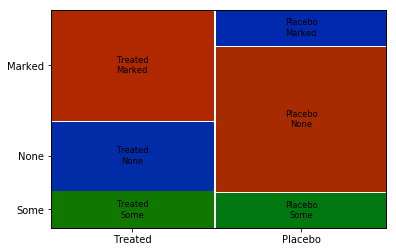

In [28]:
from statsmodels.graphics.mosaicplot import mosaic
fig,_ = mosaic(data, index=["Treatment", "Improved"], statistic=True, gap=0.01)

In [22]:
print(table.test_nominal_association())

df          2
pvalue      0.0014626434089526352
statistic   13.055019852524108


In [23]:
print(table.test_ordinal_association())

null_mean   34.166666666666664
null_sd     3.167089382058727
pvalue      0.023644578093923983
statistic   27.0
zscore      -2.262855828214126


## XLSX Writer

In [6]:
%load_ext autoreload
%autoreload

from pa_lib.file import write_xlsx as xlsw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.DataFrame({'Text': 'a b c d e f g h i j l k p o i u z t r e w q a s d f g h j k l m n b'.split(), 'Nr': list(range(34))})

In [10]:
xlsw(df, 'testfile.xlsx')

## Facets

In [1]:
from IPython.core.display import display, HTML

In [5]:
def dive(df):
    jsonstr = df.to_json(orient='records')
    html = f"""
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
            <facets-dive id="elem" height="800"></facets-dive>
            <script>
              var data = {jsonstr};
              document.querySelector("#elem").data = data;
            </script>"""
    display(HTML(html))

In [6]:
dive(df)